Saved: ../data/students.csv  (rows: 250)

--- HEAD (5 rows) ---
 student_id             name class  comprehension  attention  focus  retention  assessment_score  engagement_time
          1      Andre Adams   7th             46         70     45         61                54               68
          2   Carlos Schultz  10th             53         63     73         70                65               88
          3      Joseph Owen   8th             67         72     89         39                49               22
          4 Katherine Santos   6th             77         83     75         58                71               61
          5     Joseph Ellis   6th             41         62     42         40                50               36

--- SHAPE ---
(250, 9)

--- MISSING VALUES ---
student_id          0
name                0
class               0
comprehension       0
attention           0
focus               0
retention           0
assessment_score    0
engagement_time     0
dtype:

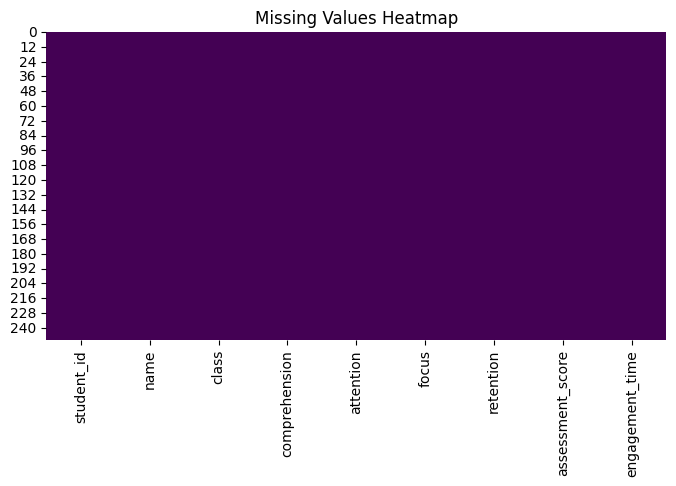

student_id          0
name                0
class               0
comprehension       0
attention           0
focus               0
retention           0
assessment_score    0
engagement_time     0
dtype: int64


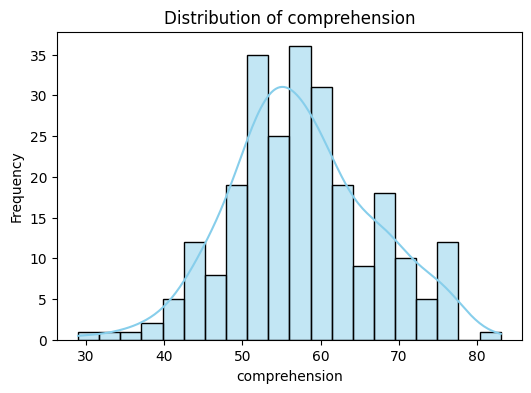

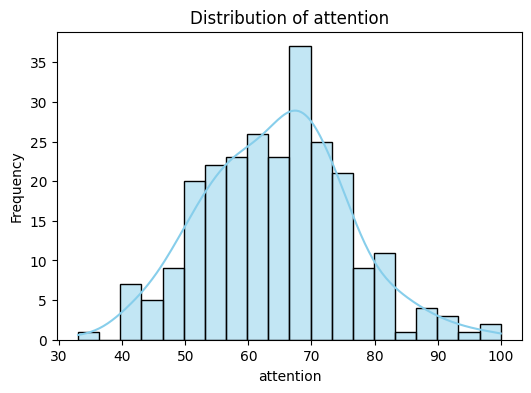

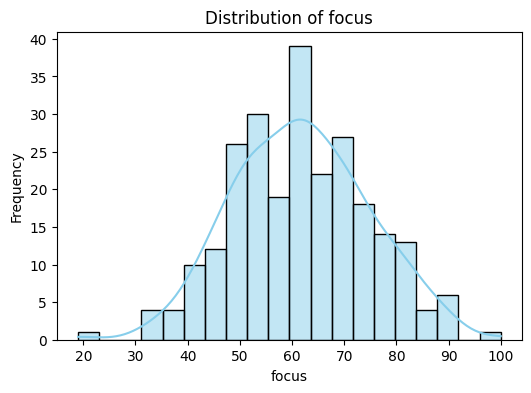

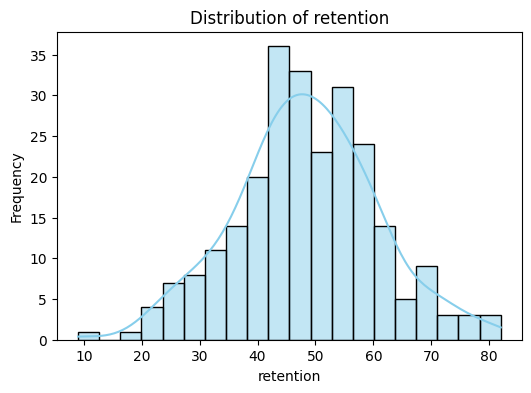

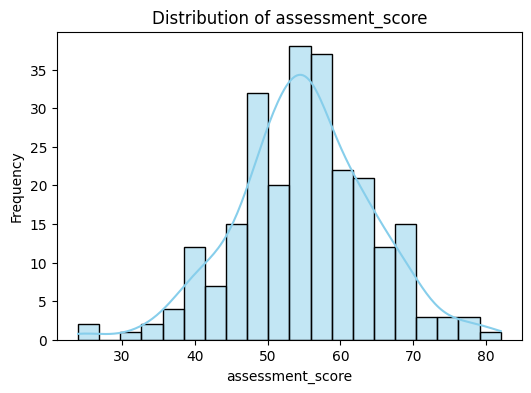

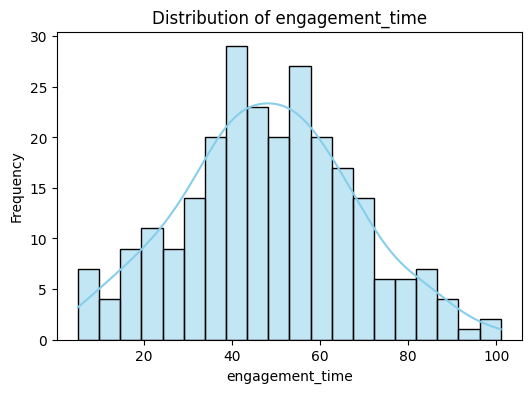

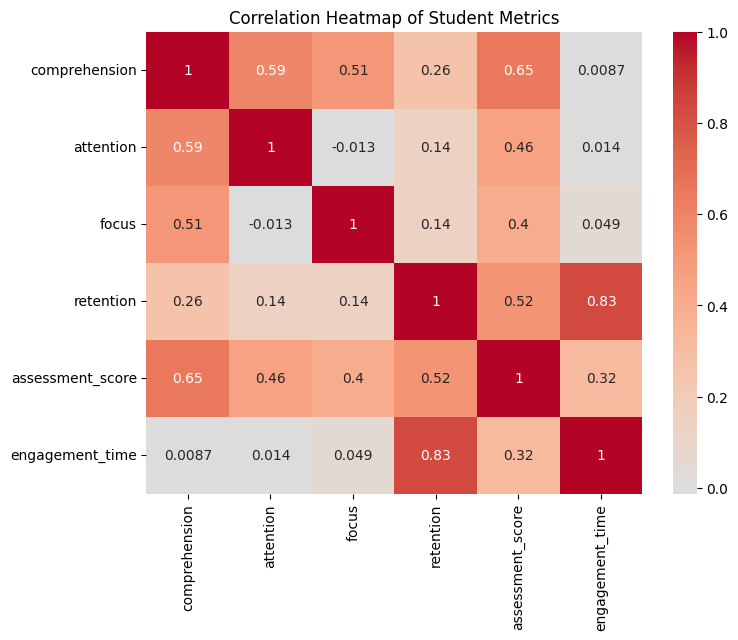

cluster
2    92
0    91
1    67
Name: count, dtype: int64

In [2]:
# === Phase 2: Synthetic dataset generator (copy-paste into analysis.ipynb) ===

import os
import numpy as np
import pandas as pd
from faker import Faker
import matplotlib.pyplot as plt
import seaborn as sns

# ---- Config ----
SEED = 42
np.random.seed(SEED)
fake = Faker()
n = 250   # between 200 and 300 rows
out_csv = "../data/students.csv"   # will save to project_root/data/students.csv
os.makedirs(os.path.dirname(out_csv), exist_ok=True)
os.makedirs("../docs/plots", exist_ok=True)

# ---- Sample distributions ----
# attention and focus: core cognitive signals (0-100)
attention = np.random.normal(loc=65, scale=12, size=n)   # mean ~65
focus     = np.random.normal(loc=62, scale=13, size=n)   # mean ~62

# engagement_time (minutes per day): correlated with retention
engagement_time = np.random.normal(loc=50, scale=20, size=n)  # typical 20-80, but we'll clamp

# comprehension: influenced by attention & focus (plus small noise)
# Use weighted sum then clamp to 0-100
comprehension = 0.45 * attention + 0.45 * focus + np.random.normal(loc=0, scale=6, size=n)

# retention: strongly correlated with engagement_time and comprehension
# Scale engagement_time to 0-100 before mixing
eng_scale = np.clip((engagement_time - engagement_time.min()) / (engagement_time.max() - engagement_time.min()), 0, 1) * 100
retention = 0.4 * comprehension + 0.5 * eng_scale + np.random.normal(0, 6, size=n)

# assessment_score: target variable influenced by comprehension, attention, focus, retention
# Give slightly more weight to comprehension & retention, include noise.
assessment_score = (
    0.35 * comprehension +
    0.2 * attention +
    0.15 * focus +
    0.25 * retention +
    np.random.normal(0, 6, size=n)
)

# ---- Clamping & sensible rounding ----
def clamp_and_round(arr, low=0, high=100, integer=True):
    arr = np.clip(arr, low, high)
    return arr.astype(int) if integer else arr

attention = clamp_and_round(attention)
focus = clamp_and_round(focus)
comprehension = clamp_and_round(comprehension)
engagement_time = clamp_and_round(engagement_time, low=5, high=240, integer=True)  # minutes/day
retention = clamp_and_round(retention)
assessment_score = clamp_and_round(assessment_score)

# ---- Other fields ----
classes = np.random.choice(["6th","7th","8th","9th","10th"], size=n, p=[0.18,0.2,0.22,0.2,0.2])
names = [fake.first_name() + " " + fake.last_name() for _ in range(n)]
student_id = np.arange(1, n+1)

# ---- Assemble DataFrame ----
df = pd.DataFrame({
    "student_id": student_id,
    "name": names,
    "class": classes,
    "comprehension": comprehension,
    "attention": attention,
    "focus": focus,
    "retention": retention,
    "assessment_score": assessment_score,
    "engagement_time": engagement_time
})

# Save CSV
df.to_csv(out_csv, index=False)
print(f"Saved: {out_csv}  (rows: {len(df)})")

# ---- Quick sanity checks (printed) ----
print("\n--- HEAD (5 rows) ---")
print(df.head().to_string(index=False))

print("\n--- SHAPE ---")
print(df.shape)

print("\n--- MISSING VALUES ---")
print(df.isnull().sum())

print("\n--- SUMMARY STATS (numeric) ---")
print(df.describe().T[["count","mean","std","min","25%","50%","75%","max"]])

# ---- Correlations we care about ----
corr = df[["comprehension","attention","focus","retention","assessment_score","engagement_time"]].corr()
print("\n--- KEY CORRELATIONS (partial view) ---")
print(corr.loc[["attention","focus","engagement_time"], ["assessment_score","comprehension","retention"]])

# ---- Save correlation heatmap and histograms for visual sanity ----
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="Blues")
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.savefig("../docs/plots/corr_heatmap.png", dpi=150)
plt.close()

# Histograms for key columns
for col in ["assessment_score","comprehension","attention","focus","retention","engagement_time"]:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], bins=20, kde=True)
    plt.title(f"Distribution: {col}")
    plt.tight_layout()
    plt.savefig(f"../docs/plots/dist_{col}.png", dpi=150)
    plt.close()

print("\nSaved plots to ../docs/plots/ (corr_heatmap.png and dist_*.png).")

# 1. Load dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("../data/students.csv")
df.head()

# 2. Basic dataset info
df.info()

# 3. Summary stats
df.describe()

# 4. Missing values
plt.figure(figsize=(8,4))
sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Values Heatmap")
plt.show()

print(df.isnull().sum())

# 5. Distribution plots
numeric_cols = ["comprehension", "attention", "focus", 
                "retention", "assessment_score", "engagement_time"]

for col in numeric_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], bins=20, kde=True, color="skyblue")
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()

# 6. Correlation heatmap
plt.figure(figsize=(8,6))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap of Student Metrics")
plt.show()





from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import os

# Features for clustering
X = df[["comprehension", "attention", "focus", "retention", "assessment_score", "engagement_time"]]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Run KMeans (choose k=3 here)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df["cluster"] = kmeans.fit_predict(X_scaled)

# Save updated dataset
os.makedirs("../data", exist_ok=True)
df.to_csv("../data/students_with_clusters.csv", index=False)

df["cluster"].value_counts()


In [3]:
# Cluster means (interpretable)
cluster_means = df.groupby("cluster")[["attention", "focus", "assessment_score"]].mean()
print("Cluster Means:\n", cluster_means)

# Print centroids (scaled space)
print("\nRaw KMeans Centroids (scaled features):\n", kmeans.cluster_centers_)


Cluster Means:
          attention      focus  assessment_score
cluster                                        
0        58.164835  59.230769         53.791209
1        74.850746  69.716418         64.074627
2        63.097826  58.336957         49.532609

Raw KMeans Centroids (scaled features):
 [[-0.54348665 -0.5522377  -0.19227239  0.54207781 -0.12811053  0.71964062]
 [ 1.18828442  0.91338144  0.62026822  0.55966457  0.9800859   0.20453869]
 [-0.32780187 -0.11894485 -0.2615346  -0.94376747 -0.58704018 -0.86077596]]


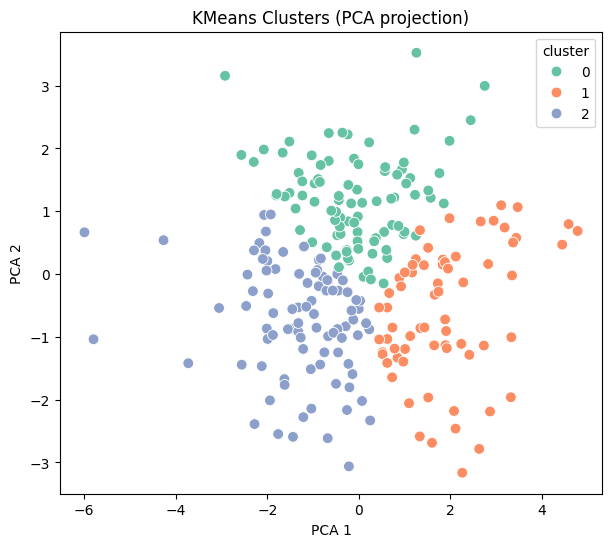

In [4]:
# PCA for 2D visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(7,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df["cluster"], palette="Set2", s=60)
plt.title("KMeans Clusters (PCA projection)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")

# Save plot
os.makedirs("../docs/plots", exist_ok=True)
plt.savefig("../docs/plots/kmeans_pca.png", dpi=300)
plt.show()


In [5]:
import json

# Load clustered dataset
df = pd.read_csv("../data/students_with_clusters.csv")

# Convert to records for frontend
records = df.to_dict(orient="records")

with open("../web/nextjs-app/public/data.json", "w") as f:
    json.dump(records, f, indent=2)

print("Saved: ../web/nextjs-app/public/data.json")


Saved: ../web/nextjs-app/public/data.json
